# **How to Standardize and Profile Chemical Structures with RDKit**

Chemical structure standardization and descriptor calculation are foundational steps in modern drug discovery pipelines and computational chemistry workflows. In this guide, I'll demonstrate essential techniques for processing, standardizing, and calculating molecular descriptors using RDKit—a powerful open-source cheminformatics toolkit widely adopted in pharmaceutical research and computational chemistry.

Computational chemists, medicinal chemists, and cheminformaticians frequently face challenges when handling molecular data from diverse sources. Variations in representation, salt forms, ionization states, and structural encoding can significantly impact downstream analyses such as QSAR modeling, virtual screening, and molecular docking. This tutorial addresses these challenges by providing a systematic approach to chemical data standardization—ensuring consistency and reproducibility across molecular datasets.

Building on my [previous post](https://brad-dallin.github.io/laptopchemistry/methods/2025-03-29-query-chembl-approved-small-molecule-drugs.html) about ChEMBL data retrieval, I'll show you how to efficiently process SMILES strings, implement a molecular preparation techniques, and calculate molecular descriptors critical for structure-property relationship studies and drug-likeness assessment. You'll learn practical RDKit functions for handling salt stripping, charge neutralization, and molecular feature extraction that can be integrated into Python-based cheminformatics pipelines.

This tutorial assumes basic familiarity with Python programming and chemical structure representation, making it ideal for computational chemists, pharmaceutical researchers, and data scientists working with chemical datasets.

I’ll be using a RDKit python environment I previously [created](https://brad-dallin.github.io/laptopchemistry/methods/2025-03-29-query-chembl-approved-small-molecule-drugs.html#python-setup) or see the [RDKit documentation](https://www.rdkit.org/docs/Install.html) for more details. The jupyter notebook for this methods post can be found [here](https://github.com/brad-dallin/laptopchemistry/blob/main/notebooks/rdkit_molecule_2d_profiling.ipynb).

### **1. Import modules**

Import `os`, `pandas`, and `rdkit` modules. `Descriptors` for calculating molecular descriptors and `rdMolStandardize` for molecule standardization are imported from `rdkit.Chem`.

Pandas display settings are adjusted to show all columns, and RDKit logging is suppressed to reduce excessive output. Finally, the versions of Pandas and RDKit are printed.

In [7]:
# Import modules
import os
import pandas as pd
import rdkit
from rdkit.Chem import Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize

# Expand to see all columns
pd.set_option('display.max_columns', None)

# Suppress RDKit Output
rdkit.RDLogger.DisableLog('rdApp.*')

# Print versions
print(f"Pandas Version: {pd.__version__}")
print(f"RDKit Version: {rdkit.__version__}")

Pandas Version: 2.2.3
RDKit Version: 2024.09.6


### **2. Create ACS 1996 drawing function**

This is my personal preference for viewing 2D chemical structures and completely optional.

This function creates a publication-quality 2D visualization of a chemical structure using the American Chemical Society's 1996 style guidelines. It processes an RDKit molecule object by computing optimal 2D coordinates, applying professional styling parameters, and returning a ready-to-display image. The result is a standardized chemical structure representation.

In [8]:
# Draw molecules in ACS1996 format
def show_acs1996(mol, legend=""):
    from PIL import Image
    from io import BytesIO
    from rdkit.Chem import Draw
    rdkit.Chem.rdDepictor.Compute2DCoords(mol)
    rdkit.Chem.rdDepictor.StraightenDepiction(mol)
    d2d = Draw.MolDraw2DCairo(-1,-1)
    Draw.DrawMoleculeACS1996(d2d, mol,legend=legend)
    bio = BytesIO(d2d.GetDrawingText())
    return Image.open(bio)

### **3. Load dataset**
Load the CSV file as a Pandas dataframe. The dataset used can be found in the notebooks folder of this repository [here](https://github.com/brad-dallin/laptopchemistry/blob/main/notebooks/data/chembl_approved_small_molecule_drugs.csv).

In [ ]:
# Paths
path_data = os.path.realpath("../data")
input_file = "chembl_approved_small_molecule_drugs.csv"
input_path = os.path.join(path_data, input_file)

# Load CSV
df = pd.read_csv(input_path)
print(df.shape)
df.head()

(3517, 53)


,chembl_molecule_id,smiles,molregno,pref_name,max_phase,therapeutic_flag,dosed_ingredient,structure_type,chebi_par_id,molecule_type,first_approval,oral,parenteral,topical,black_box_warning,natural_product,first_in_class,chirality,prodrug,inorganic_flag,usan_year,availability_type,usan_stem,polymer_flag,usan_substem,usan_stem_definition,indication_class,withdrawn_flag,chemical_probe,orphan,mw_freebase,alogp,hba,hbd,psa,rtb,ro3_pass,num_ro5_violations,cx_most_apka,cx_most_bpka,cx_logp,cx_logd,molecular_species,full_mwt,aromatic_rings,heavy_atoms,qed_weighted,mw_monoisotopic,full_molformula,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score
0,CHEMBL1200542,CC(=O)OCC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)C...,674493,DESOXYCORTICOSTERONE ACETATE,4.0,1,1,MOL,34671.0,Small molecule,1939.0,0,1,0,0,1,0,1,0,0,NaN,0.0,-cort-; -ster-; -terone,0,-cort-; -ster-; -terone,"cortisone derivatives; steroids (androgens, an...",Adrenocortical Steroid (salt-regulating),0,0,0,372.51,4.27,4.0,0.0,60.44,3.0,N,0.0,NaN,NaN,3.77,3.77,NEUTRAL,372.51,0.0,27.0,0.69,372.2301,C23H32O4,4.0,0.0,0.0,1.96
1,CHEMBL1200728,Cl.N=C(N)N,674679,GUANIDINE HYDROCHLORIDE,4.0,1,1,MOL,32735.0,Small molecule,1939.0,1,0,0,0,0,0,2,0,0,NaN,1.0,guan-,0,guan-,antihypertensives (guanidine derivatives),NaN,0,0,0,59.07,-1.16,1.0,3.0,75.89,0.0,N,0.0,NaN,12.55,-1.24,-3.65,BASE,95.53,0.0,4.0,0.24,59.0483,CH6ClN3,3.0,5.0,0.0,0.32
2,CHEMBL1200982,CCC(C)C1(CC)C(=O)[N-]C(=O)NC1=O.[Na+],674933,BUTABARBITAL SODIUM,4.0,1,1,MOL,NaN,Small molecule,1939.0,1,0,0,0,0,0,0,0,0,NaN,1.0,-barb-,0,-barb-,barbituric acid derivatives,Sedative-Hypnotic,0,0,0,212.25,0.79,3.0,2.0,75.27,3.0,N,0.0,7.48,NaN,1.45,1.19,NEUTRAL,234.23,0.0,15.0,0.68,212.1161,C10H15N2NaO3,5.0,2.0,0.0,0.32
3,CHEMBL3989520,NCCc1c[nH]cn1.O=P(O)(O)O.O=P(O)(O)O,2197391,HISTAMINE PHOSPHATE,4.0,1,1,MOL,NaN,Small molecule,1939.0,0,1,0,1,0,0,2,0,0,NaN,0.0,NaN,0,NaN,NaN,NaN,0,0,0,111.15,-0.09,2.0,2.0,54.70,2.0,Y,0.0,NaN,9.58,-0.70,-2.85,BASE,307.14,1.0,8.0,0.56,111.0796,C5H15N3O8P2,3.0,3.0,0.0,0.00
4,CHEMBL449,CCC(C)C1(CC)C(=O)NC(=O)NC1=O,2393,BUTABARBITAL,4.0,1,0,MOL,3228.0,Small molecule,1939.0,1,0,0,0,1,0,0,0,0,NaN,1.0,-barb-,0,-barb-,barbituric acid derivatives,Sedative-Hypnotic,0,0,0,212.25,0.79,3.0,2.0,75.27,3.0,N,0.0,7.48,NaN,1.45,1.19,NEUTRAL,212.25,0.0,15.0,0.68,212.1161,C10H16N2O3,5.0,2.0,0.0,0.32


### **4. Read in a molecule with RDKit**

Start by reading a single SMILES in with RDKit's `MolFromSmiles()` function. This function parses the SMILES string, then constructs a graph-based molecular representation. We'll take a look at the 11th entry, sulfadiazine sodium, which is an antibacterial drug administered as a sodium salt used to treat various bacterial infections and happens to be a nice example to demonstrate the standardization process.

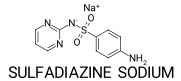

In [10]:
# Read SMILES
ii = 10
smi = df["smiles"].iloc[ii]
id = df["pref_name"].iloc[ii]
mol = rdkit.Chem.MolFromSmiles(
    smi,
    sanitize = False
)
show_acs1996(mol, legend=id)

### **5. Process the molecule object**
Molecular standardization represents one of the most critical steps in cheminformatics. Three key processing steps are implemented here:

**Sanitization**

This step involves cleaning up the molecule and checking chemical consistency (*e.g.*, valence, kekulize, etc.). See the [RDKit book](https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization) for details.

Without proper sanitization, downstream calculations may produce nonsensical results or fail entirely. RDKit's sanitization is particularly thorough.

**Largest Fragment Extraction** 

This step addresses an important challenge in chemical datasets: many entries represent salts or mixtures rather than single compounds. The `LargestFragmentChooser()` and `chooseInPlace()` function analyzes the molecular graph to identify disconnected components, returning the largest connected subgraph. In our example, this removes the Na ion.

**Neutralization (uncharging)**

This step standardizes the ionization state of molecules, which can vary significantly depending on the source database and pH assumptions.

This step is particularly important when calculating physicochemical descriptors that depend on ionization state, such as logP values. However, it should be applied cautiously, as bioactive conformations may require specific charge states for receptor binding.

Compare the molecule images below to the one above to see the ion and charge neutralized.

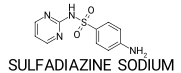

In [11]:
# Sanitize, extract the largest fragment, and uncharge
rdkit.Chem.SanitizeMol(mol)
largest_frag_app = rdMolStandardize.LargestFragmentChooser()
uncharge_app = rdMolStandardize.Uncharger()
largest_frag_app.chooseInPlace(mol)
uncharge_app.unchargeInPlace(mol)
show_acs1996(mol, legend=id)

### **6. Calculate RDKit molecular descriptors**
RDKit has a lot of molecular descriptors, in fact, 217 at the writing of this post. The descriptors functions can be accessed from the `Descriptors` app in the `rdkit.Chem` module. Then looping through the `_descList` dictionary, all the descriptors can be calculated for each molecule. Subsets of descriptors can be calculated, if specific descriptors are needed.

In [12]:
# Calculate all RDKit descriptors
descriptors = {
    "SMILES": rdkit.Chem.MolToSmiles(mol),
}
for descriptor, fxn in rdkit.Chem.Descriptors._descList:
    try:
        value = fxn(mol)
    except Exception as e:
        value = None
    descriptors[f"{descriptor}"] = value
descriptors

{'SMILES': 'Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1',
 'MaxAbsEStateIndex': np.float64(11.880950491307635),
 'MaxEStateIndex': np.float64(11.880950491307635),
 'MinAbsEStateIndex': np.float64(0.03178240740740779),
 'MinEStateIndex': np.float64(-3.6606481481481468),
 'qed': 0.7871395577774678,
 'SPS': None,
 'MolWt': 250.28300000000004,
 'HeavyAtomMolWt': 240.20299999999997,
 'ExactMolWt': 250.05244656,
 'NumValenceElectrons': 88,
 'NumRadicalElectrons': 0,
 'MaxPartialCharge': 0.2637233954888739,
 'MinPartialCharge': -0.39872771712743976,
 'MaxAbsPartialCharge': 0.39872771712743976,
 'MinAbsPartialCharge': 0.2637233954888739,
 'FpDensityMorgan1': None,
 'FpDensityMorgan2': None,
 'FpDensityMorgan3': None,
 'BCUT2D_MWHI': 32.23327104557692,
 'BCUT2D_MWLOW': 10.319170390655504,
 'BCUT2D_CHGHI': 2.1415057650483593,
 'BCUT2D_CHGLO': -2.0546834089334234,
 'BCUT2D_LOGPHI': 2.136710750473383,
 'BCUT2D_LOGPLOW': -2.1428245429362125,
 'BCUT2D_MRHI': 7.923068764373256,
 'BCUT2D_MRLOW': 0.600567336991237,


### **7. Loop through all molecules and merge descriptors with original dataframe**
The final two cells show how to bring the previous steps together in a loop to process all the molecules in the dataset and merge the calculated descriptors with the original dataset.  If SMILES are missing, the program skips them.

The try/except pattern is crucial because SMILES strings from public databases may fail to parse correctly. When processing thousands of molecules, robust error handling prevents pipeline failures due to individual problematic structures.

In [13]:
# Run for all compounds
largest_frag_app = rdMolStandardize.LargestFragmentChooser()
uncharge_app = rdMolStandardize.Uncharger()
mols = []
unique_smiles = []
skipped_indices = []
for ii, smi in enumerate(df["smiles"]):
    try:
        mol = rdkit.Chem.MolFromSmiles(
            smi,
            sanitize = False
        )
        assert mol is not None
    except Exception as e:
        skipped_indices.append(ii)
        if pd.notna(smi):
            print(f"Error processing SMILES at index {ii}: {smi}")
            print(f"Exception: {e}")
        continue
    try:
        rdkit.Chem.SanitizeMol(mol)
        largest_frag_app.chooseInPlace(mol)
        uncharge_app.unchargeInPlace(mol)
    except Exception as e:
        skipped_indices.append(ii)
        print(f"Error processing molecule at index {ii}")
        print(f"Exception: {e}")
        continue
    frag_smi = rdkit.Chem.MolToSmiles(mol)
    if frag_smi in unique_smiles:
        skipped_indices.append(ii)
        continue
    descriptors = {
        "idx": ii,
        "SMILES": frag_smi,
    }
    for descriptor, fxn in Descriptors._descList:
        try:
            value = fxn(mol)
        except Exception as e:
            value = None
        descriptors[f"rdkit_{descriptor}"] = value
    mols.append(descriptors)
    unique_smiles.append(frag_smi)

print(f"{len(mols)}/{df.shape[0]} molecules processed!")
print(f"{df.shape[0]-len(mols)}/{df.shape[0]} molecules skipped!")

2292/3517 molecules processed!
1225/3517 molecules skipped!


In [14]:
# Update dataframe with RDKit descriptors
column_update = { cc: f"chembl_{cc}" for cc in df.columns[1:] }
df = df.rename(columns=column_update)

mol_df = pd.DataFrame(mols)
mol_df.set_index("idx", inplace=True)

mol_df.columns = [ col if col == "SMILES" else col.lower() 
                   for col in mol_df.columns ]

df = pd.concat([df, mol_df], axis=1)
cols = df.columns.tolist()
cols.remove('SMILES')
cols.insert(0, 'SMILES')
df = df[cols]

# Drop skipped indices
df = df.drop(index=skipped_indices)

# Display results
print(df.shape)
df.head()
# Save to file
# df.to_csv(
#     args.output,
#     index=False,
#     encoding="utf-8"
# )

(2292, 271)


,SMILES,chembl_molecule_id,chembl_smiles,chembl_molregno,chembl_pref_name,chembl_max_phase,chembl_therapeutic_flag,chembl_dosed_ingredient,chembl_structure_type,chembl_chebi_par_id,chembl_molecule_type,chembl_first_approval,chembl_oral,chembl_parenteral,chembl_topical,chembl_black_box_warning,chembl_natural_product,chembl_first_in_class,chembl_chirality,chembl_prodrug,chembl_inorganic_flag,chembl_usan_year,chembl_availability_type,chembl_usan_stem,chembl_polymer_flag,chembl_usan_substem,chembl_usan_stem_definition,chembl_indication_class,chembl_withdrawn_flag,chembl_chemical_probe,chembl_orphan,chembl_mw_freebase,chembl_alogp,chembl_hba,chembl_hbd,chembl_psa,chembl_rtb,chembl_ro3_pass,chembl_num_ro5_violations,chembl_cx_most_apka,chembl_cx_most_bpka,chembl_cx_logp,chembl_cx_logd,chembl_molecular_species,chembl_full_mwt,chembl_aromatic_rings,chembl_heavy_atoms,chembl_qed_weighted,chembl_mw_monoisotopic,chembl_full_molformula,chembl_hba_lipinski,chembl_hbd_lipinski,chembl_num_lipinski_ro5_violations,chembl_np_likeness_score,rdkit_maxabsestateindex,rdkit_maxestateindex,rdkit_minabsestateindex,rdkit_minestateindex,rdkit_qed,rdkit_sps,rdkit_molwt,rdkit_heavyatommolwt,rdkit_exactmolwt,rdkit_numvalenceelectrons,rdkit_numradicalelectrons,rdkit_maxpartialcharge,rdkit_minpartialcharge,rdkit_maxabspartialcharge,rdkit_minabspartialcharge,rdkit_fpdensitymorgan1,rdkit_fpdensitymorgan2,rdkit_fpdensitymorgan3,rdkit_bcut2d_mwhi,rdkit_bcut2d_mwlow,rdkit_bcut2d_chghi,rdkit_bcut2d_chglo,rdkit_bcut2d_logphi,rdkit_bcut2d_logplow,rdkit_bcut2d_mrhi,rdkit_bcut2d_mrlow,rdkit_avgipc,rdkit_balabanj,rdkit_bertzct,rdkit_chi0,rdkit_chi0n,rdkit_chi0v,rdkit_chi1,rdkit_chi1n,rdkit_chi1v,rdkit_chi2n,rdkit_chi2v,rdkit_chi3n,rdkit_chi3v,rdkit_chi4n,rdkit_chi4v,rdkit_hallkieralpha,rdkit_ipc,rdkit_kappa1,rdkit_kappa2,rdkit_kappa3,rdkit_labuteasa,rdkit_peoe_vsa1,rdkit_peoe_vsa10,rdkit_peoe_vsa11,rdkit_peoe_vsa12,rdkit_peoe_vsa13,rdkit_peoe_vsa14,rdkit_peoe_vsa2,rdkit_peoe_vsa3,rdkit_peoe_vsa4,rdkit_peoe_vsa5,rdkit_peoe_vsa6,rdkit_peoe_vsa7,rdkit_peoe_vsa8,rdkit_peoe_vsa9,rdkit_smr_vsa1,rdkit_smr_vsa10,rdkit_smr_vsa2,rdkit_smr_vsa3,rdkit_smr_vsa4,rdkit_smr_vsa5,rdkit_smr_vsa6,rdkit_smr_vsa7,rdkit_smr_vsa8,rdkit_smr_vsa9,rdkit_slogp_vsa1,rdkit_slogp_vsa10,rdkit_slogp_vsa11,rdkit_slogp_vsa12,rdkit_slogp_vsa2,rdkit_slogp_vsa3,rdkit_slogp_vsa4,rdkit_slogp_vsa5,rdkit_slogp_vsa6,rdkit_slogp_vsa7,rdkit_slogp_vsa8,rdkit_slogp_vsa9,rdkit_tpsa,rdkit_estate_vsa1,rdkit_estate_vsa10,rdkit_estate_vsa11,rdkit_estate_vsa2,rdkit_estate_vsa3,rdkit_estate_vsa4,rdkit_estate_vsa5,rdkit_estate_vsa6,rdkit_estate_vsa7,rdkit_estate_vsa8,rdkit_estate_vsa9,rdkit_vsa_estate1,rdkit_vsa_estate10,rdkit_vsa_estate2,rdkit_vsa_estate3,rdkit_vsa_estate4,rdkit_vsa_estate5,rdkit_vsa_estate6,rdkit_vsa_estate7,rdkit_vsa_estate8,rdkit_vsa_estate9,rdkit_fractioncsp3,rdkit_heavyatomcount,rdkit_nhohcount,rdkit_nocount,rdkit_numaliphaticcarbocycles,rdkit_numaliphaticheterocycles,rdkit_numaliphaticrings,rdkit_numamidebonds,rdkit_numaromaticcarbocycles,rdkit_numaromaticheterocycles,rdkit_numaromaticrings,rdkit_numatomstereocenters,rdkit_numbridgeheadatoms,rdkit_numhacceptors,rdkit_numhdonors,rdkit_numheteroatoms,rdkit_numheterocycles,rdkit_numrotatablebonds,rdkit_numsaturatedcarbocycles,rdkit_numsaturatedheterocycles,rdkit_numsaturatedrings,rdkit_numspiroatoms,rdkit_numunspecifiedatomstereocenters,rdkit_phi,rdkit_ringcount,rdkit_mollogp,rdkit_molmr,rdkit_fr_al_coo,rdkit_fr_al_oh,rdkit_fr_al_oh_notert,rdkit_fr_arn,rdkit_fr_ar_coo,rdkit_fr_ar_n,rdkit_fr_ar_nh,rdkit_fr_ar_oh,rdkit_fr_coo,rdkit_fr_coo2,rdkit_fr_c_o,rdkit_fr_c_o_nocoo,rdkit_fr_c_s,rdkit_fr_hoccn,rdkit_fr_imine,rdkit_fr_nh0,rdkit_fr_nh1,rdkit_fr_nh2,rdkit_fr_n_o,rdkit_fr_ndealkylation1,rdkit_fr_ndealkylation2,rdkit_fr_nhpyrrole,rdkit_fr_sh,rdkit_fr_aldehyde,rdkit_fr_alkyl_carbamate,rdkit_fr_alkyl_halide,rdkit_fr_allylic_oxid,rdkit_fr_amide,rdkit_fr_amidine,rdkit_fr_aniline,rdkit_fr_aryl_methyl,rdkit_fr_azide,rdkit_fr_azo,rdkit_fr_barbitur,rdkit_fr_ben

## Conclusion

In this tutorial, we've covered essential techniques for standardizing and analyzing chemical structures with RDKit. From SMILES processing to molecular standardization (sanitization, salt removal, and charge neutralization) to descriptor calculation. These approaches ensure consistency across chemical datasets, enabling reliable property predictions and comparisons critical for drug discovery applications.